# **Angular Reconstruction & Cosmic Ray Classification**  
### **Luis F. Navarro** – luis.navarrof@usm.cl  
#### **2025**

#### This notebook addresses the classification of cosmic rays (photons vs protons) and the accurate reconstruction of their arrival angle using simulated data from the CONDOR observatory. The workflow includes: data loading and preprocessing, class and angle balancing, exploratory visualization, normalization and sequence assembly, and the construction of deep learning models (1D CNN + MultiHeadAttention) for classification and regression. Oversampling/undersampling techniques are used to ensure a balanced dataset by angle and particle, and a stratified train/val/test split is performed. Finally, detailed metrics and visualizations of performance for both tasks are presented, along with error analysis and prediction dispersion. Each section contains explanatory comments about the steps and their relevance.


#### Import libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cb_early = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
cb_rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

### _Optional: Configure Tensorflow to reduce memory waste_

In [ ]:
# Para evitar errores de memoria en GPU
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

### Define incident energy and the types of cosmic rays to predict (Photon and Proton)

In [42]:
# Parámetros generales
energies    = ['5E2', '8E2']
particles   = ["Photon", "Proton"]
base_dir    = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR_ChPT_Datasets"
predicts_dir = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\Results"
if not os.path.exists(predicts_dir):
    os.makedirs(predicts_dir)

plt.style.use('seaborn-v0_8-whitegrid')

### Some useful functions to define:

- **F1-metric.** To use it later in classification training.
- **Rotate-shower.** Auxiliary function to augment data by rotating particle showers _(currently not used)_.
- **Compute-Radial-Profile.** Auxiliary function to calculate the number of particles impacting in concentric rings around the shower _(currently not used)_.
- **Build-sequence.** Essential function that constructs each sequence corresponding to each particle shower.

In [43]:
# Métrica F1 para clasificación
def f1_metric(y_true, y_pred):
    y_pred_binary = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred_binary, 'float32'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred_binary), 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred_binary, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred_binary), 'float32'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)

In [ ]:
# -------------------------------
# 1) FUNCIONES AUXILIARES
# -------------------------------

def rotate_shower(df, phi):
    """
    Rota los puntos (x_bin, y_bin) alrededor del origen por ángulo phi [rad].
    Devuelve un DataFrame rotado con las mismas columnas, solo modifica x_bin,y_bin.
    """
    r = np.sqrt(df['x_bin']**2 + df['y_bin']**2)
    theta = np.arctan2(df['y_bin'], df['x_bin'])
    theta_rot = theta + phi
    x_new = r * np.cos(theta_rot)
    y_new = r * np.sin(theta_rot)
    df_r = df.copy()
    df_r['x_bin'] = x_new
    df_r['y_bin'] = y_new
    return df_r

def compute_radial_profile(df, bin_edges):
    """
    Dado un DataFrame de ducha (x_bin,y_bin,particle_count), 
    calcula la suma de particle_count en anillos definidos por bin_edges.
    Retorna un vector de longitud len(bin_edges)-1.
    """
    x = df['x_bin'].values
    y = df['y_bin'].values
    cnt = df['particle_count'].values
    r = np.sqrt(x**2 + y**2)
    sums, _ = np.histogram(r, bins=bin_edges, weights=cnt)
    return sums.astype(np.float32)

def build_sequence(df):
    """
    Dado un DataFrame df con columnas normalizadas [x_bin,y_bin,t_bin], 
    construye la secuencia (x_bin, y_bin, t_bin)
    """
    xs = df['x_bin'].values
    ys = df['y_bin'].values
    ts = df['t_bin'].values
    seq = np.stack([
        xs.astype(np.float32),
        ys.astype(np.float32),
        ts.astype(np.float32)
    ], axis=1)
        
    # Ordenar por tiempo
    idx_sort = np.argsort(seq[:, 2])
    return seq[idx_sort]


### Data reading and processing.
#### Creation of lists to store the loaded data.

- **Aug_seqs.** Contains the sequences of particle showers and their variables (x_bin, y_bin, and t_bin).
- **Aug_angles.** Labels corresponding to the incidence angle of each sequence.
- **Aug_labels.** Correspond to the particle type labels (0: Proton, 1: Photon).
- **tp_list.** List that stores the total number of particles generated by each sequence.
- **mt_list.** Stores the maximum durations of each sequence.

In [ ]:
# -------------------------------
# RECOLECCIÓN, LECTURA Y PROCESAMIENTO DE DATOS EN UN SOLO PASO
# -------------------------------

file_paths = []
energy_labels = []
aug_seqs  = []
aug_angles= []
aug_labels= []
aug_energies = []
tp_list   = []
mt_list   = []

all_x = []
all_y = []
all_t = []

for energy in energies:
    for part in particles:
        label = 0 if part == "Proton" else 1
        folder = os.path.join(base_dir, f"CONDOR_{energy}_{part}_ChPt", "binned_data")
        if not os.path.isdir(folder):
            continue
        for run_f in os.listdir(folder):
            run_p = os.path.join(folder, run_f)
            if not (os.path.isdir(run_p) and run_f.startswith("run_")):
                continue
            for csv_f in os.listdir(run_p):
                if not csv_f.endswith(".csv"):
                    continue
                path = os.path.join(run_p, csv_f)
                if os.stat(path).st_size == 0:
                    continue
                try:
                    angle = float(csv_f.split("_")[7])
                except:
                    continue
                if angle > 50.0:
                    continue

                # Leer y procesar el archivo solo una vez
                df0 = pd.read_csv(path)
                total_p = len(df0)
                if total_p < 5: # Filtrar mínimo de partículas
                    continue

                max_t = df0['t_bin'].max()
                seq = df0[['x_bin', 'y_bin', 't_bin']].values.astype(np.float32)
                idx_sort = np.argsort(seq[:, 2])
                seq = seq[idx_sort]

                # Guardar para procesamiento posterio
                file_paths.append((path, angle, label))
                energy_labels.append(energy)
                aug_seqs.append(seq)
                aug_angles.append(angle)
                aug_labels.append(label)
                aug_energies.append(energy)
                tp_list.append(total_p)
                mt_list.append(max_t)

                # Para los scalers
                all_x.append(df0['x_bin'].values)
                all_y.append(df0['y_bin'].values)
                all_t.append(df0['t_bin'].values)

# Ajustar scalers después de recolectar todos los datos
all_x = np.concatenate(all_x).reshape(-1, 1)
all_y = np.concatenate(all_y).reshape(-1, 1)
all_t = np.concatenate(all_t).reshape(-1, 1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(all_x)
scaler_y.fit(all_y)
scaler_t.fit(all_t)

MinMaxScaler()

In [47]:
# 5) Extra features (total_particles y max_time) SIN normalizar
tp_arr = np.array(tp_list, dtype=np.float32)
mt_arr = np.array(mt_list, dtype=np.float32)

X_extra_full = np.stack([tp_arr, mt_arr], axis=1).astype(np.float32)

### Visualization of the data distribution by angle and particle type.

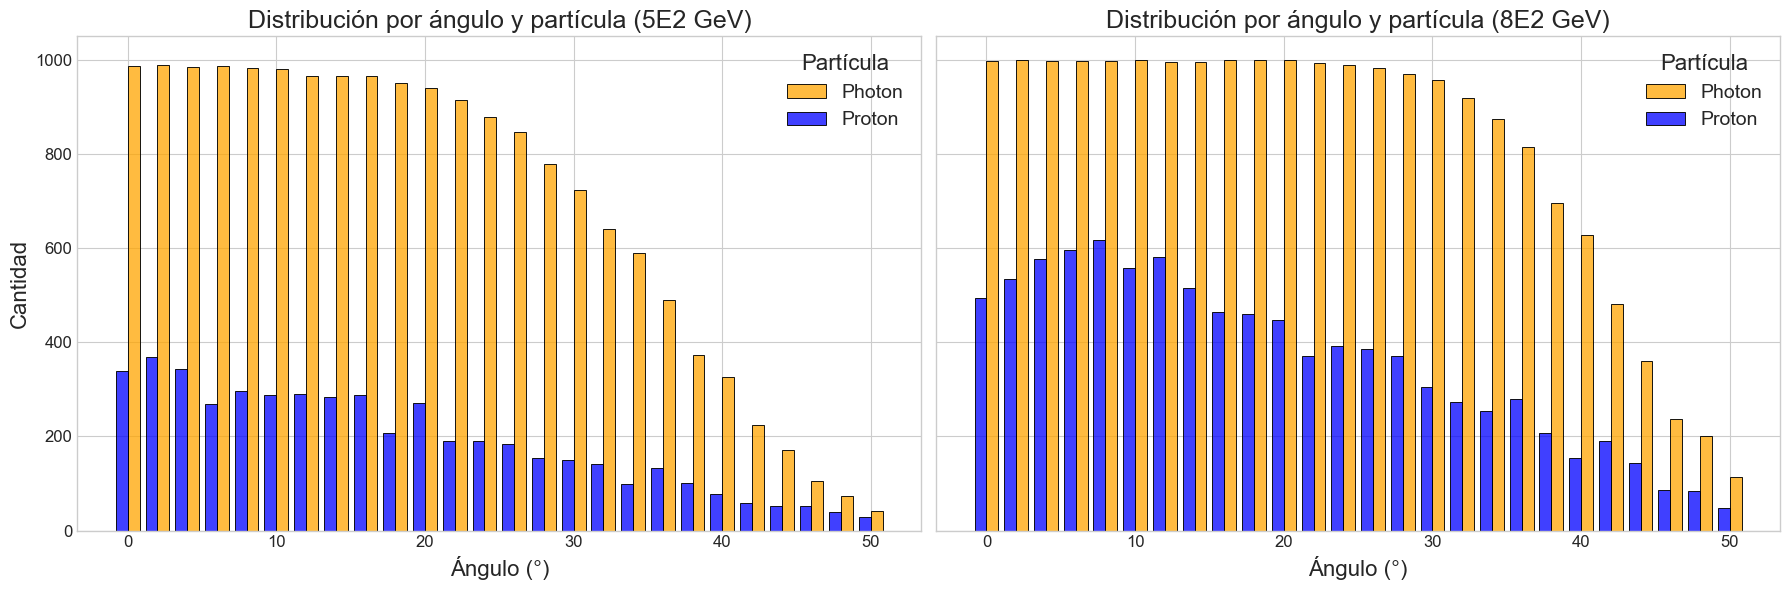

In [48]:
# Visualización de la distribución de ángulo y partícula para todas las energías presentes en los datos
df_dist = pd.DataFrame({
    'angle': aug_angles,
    'label': aug_labels,
    'energy': aug_energies
})
df_dist['particle'] = df_dist['label'].map({0: 'Proton', 1: 'Photon'})

unique_energies = sorted(df_dist['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    ax = axes[i]
    df_e = df_dist[df_dist['energy'] == energy_val]
    sns.histplot(
        data=df_e,
        x='angle',
        hue='particle',
        bins=np.arange(-1, 52, 2),
        multiple='dodge',
        shrink=0.8,
        palette={'Photon': 'orange', 'Proton': 'blue'},
        hue_order=['Proton', 'Photon'],
        ax=ax
    )
    ax.set_xlabel("Ángulo (°)", fontsize=16)
    ax.set_ylabel("Cantidad", fontsize=16)
    ax.set_title(f"Distribución por ángulo y partícula ({energy_val} GeV)", fontsize=18)
    ax.legend(title="Partícula", labels=["Photon", "Proton"], fontsize=14, title_fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "angle_label_distribution_by_energy.png"))
plt.show()

### Sequence balancing (1000 sequences per angle for both particles).

In [ ]:
# Armado de DataFrame para conteos por (angle,label,energy)
df_full = pd.DataFrame({
    'angle': aug_angles,
    'label': aug_labels,
    'energy': aug_energies
})

# Para hacer undersample/oversample, nos servirá el índice en df_full

target = 500

# BALANCEAR a 500 muestras por (angle,label,energy) para cualquier cantidad de energías
df_full['idx'] = np.arange(len(df_full))
chosen = []
for energy_val in sorted(df_full['energy'].unique()):
    angles = sorted(df_full[df_full.energy == energy_val]['angle'].unique())
    for ang in angles:
        for lbl in [0, 1]:
            idxs = df_full[(df_full.energy == energy_val) & (df_full.angle == ang) & (df_full.label == lbl)]['idx'].values
            n = len(idxs)
            if n == 0:
                continue
            if n >= target:
                pick = np.random.choice(idxs, size=target, replace=False)
            else:
                extra = target - n
                pick = np.concatenate([idxs, np.random.choice(idxs, size=extra, replace=True)])
            chosen.extend(pick.tolist())

In [ ]:
# Generar subconjunto balanceado
chosen = np.array(chosen, dtype=int)
aug_seqs = np.array(aug_seqs, dtype=object)
aug_angles = np.array(aug_angles)
aug_labels = np.array(aug_labels)
aug_energies = np.array(aug_energies)

X_seq_bal = aug_seqs[chosen]
X_ext_bal = X_extra_full[chosen]
y_ang_bal = aug_angles[chosen]
y_lbl_bal = aug_labels[chosen]
y_energy_bal = aug_energies[chosen]

df_bal = pd.DataFrame({'angle': y_ang_bal, 'label': y_lbl_bal, 'energy': y_energy_bal})


### Visualization of the data removed and added after balancing

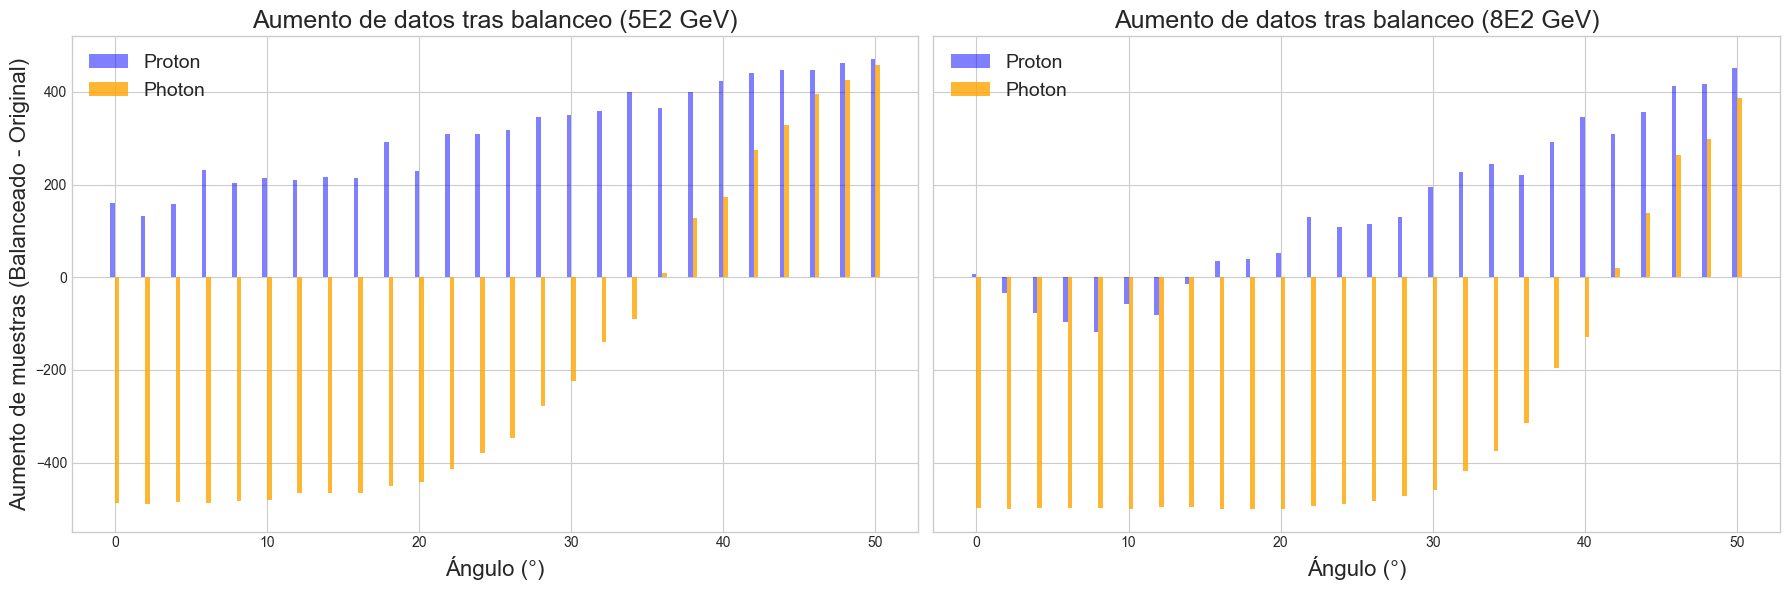

In [76]:
# Calcular la cantidad de datos originales y balanceados por ángulo y partícula, separado por energía (generalizado para cualquier cantidad de energías)
unique_energies = sorted(df_dist['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    # Filtrar por energía
    orig_counts = df_dist[df_dist['energy'] == energy_val][['angle', 'label']].value_counts().sort_index()
    bal_counts = df_bal[df_bal['energy'] == energy_val][['angle', 'label']].value_counts().sort_index()

    angles = np.sort(np.unique(np.concatenate([orig_counts.index.get_level_values(0), bal_counts.index.get_level_values(0)])))
    labels = [0, 1]  # 0=Proton, 1=Photon

    diff_matrix = np.zeros((len(angles), 2), dtype=int)
    for j, ang in enumerate(angles):
        for lbl in labels:
            orig = orig_counts.get((ang, lbl), 0)
            bal = bal_counts.get((ang, lbl), 0)
            diff_matrix[j, lbl] = bal - orig

    ax = axes[i]
    ax.bar(angles - 0.15, diff_matrix[:, 0], width=0.3, color='blue', alpha=0.5, label='Proton', zorder=1)
    ax.bar(angles + 0.15, diff_matrix[:, 1], width=0.3, color='orange', alpha=0.8, label='Photon', zorder=2)
    ax.set_xlabel("Ángulo (°)", fontsize=16)
    if i == 0:
        ax.set_ylabel("Aumento de muestras (Balanceado - Original)", fontsize=16)
    ax.set_title(f"Aumento de datos tras balanceo ({energy_val} GeV)", fontsize=18)
    ax.legend(fontsize=14)
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "balance_diff_by_angle_particle_by_energy.png"))
plt.show()

### Box-plot visualization of the total number of particles generated for all sequences at each angle.

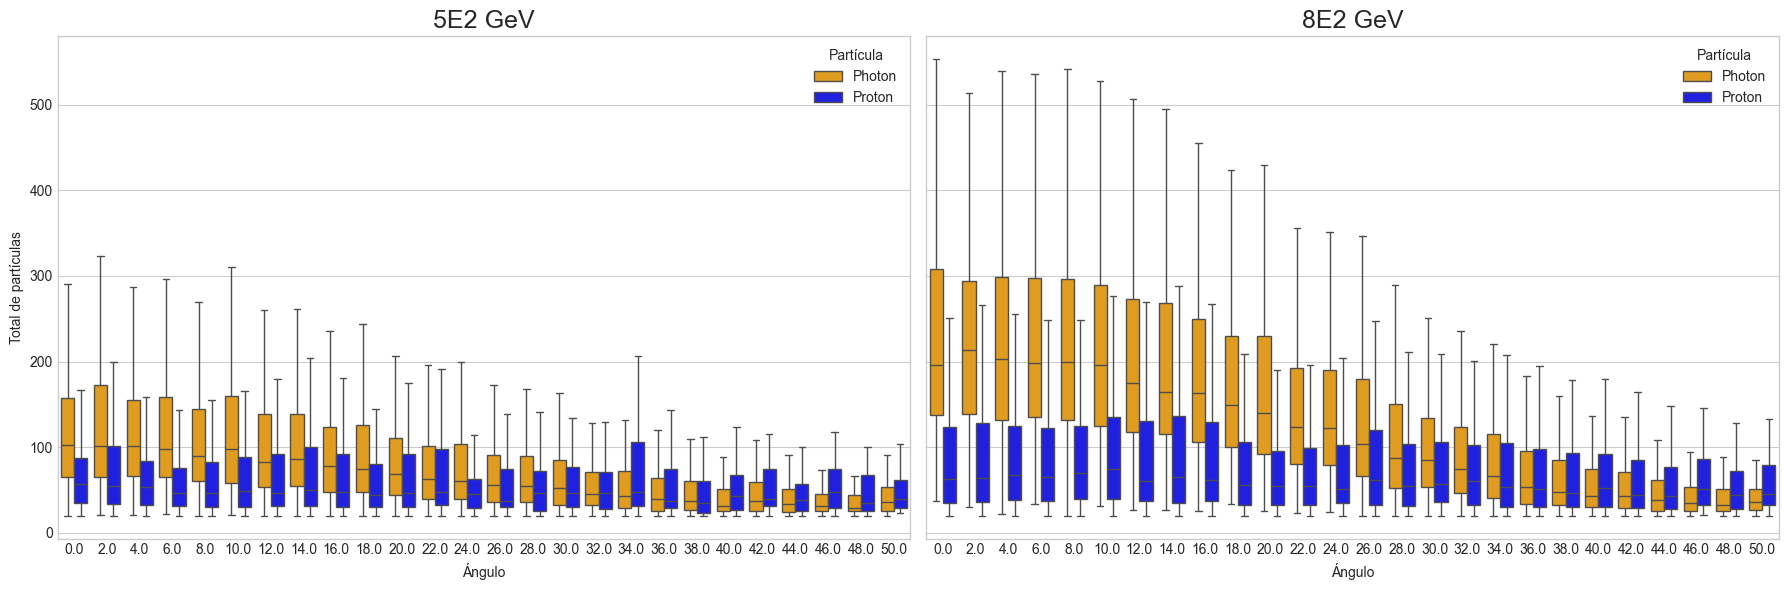

In [77]:
# Boxplot de total de partículas por ángulo y partícula, separado por energía (balanceado)

# Crear DataFrame balanceado con energía
df_bal_particles = pd.DataFrame({
    'total_particles': X_ext_bal[:, 0],
    'angle': y_ang_bal,
    'label': y_lbl_bal,
    'energy': y_energy_bal
})
df_bal_particles['particle'] = df_bal_particles['label'].map({0: 'Proton', 1: 'Photon'})

box_palette = {'Proton': 'blue', 'Photon': 'orange'}
box_kwargs = dict(
    x='angle',
    y='total_particles',
    hue='particle',
    palette=box_palette,
    showfliers=False,
    hue_order=['Photon', 'Proton']
)

unique_energies = sorted(df_bal_particles['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    sns.boxplot(
        data=df_bal_particles[df_bal_particles['energy'] == energy_val],
        ax=axes[i],
        **box_kwargs
    )
    axes[i].set_xlabel("Ángulo")
    axes[i].set_ylabel("Total de partículas")
    axes[i].set_title(f"{energy_val} GeV", fontsize=18)
    axes[i].legend(title="Partícula")

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "boxplot_total_particles_by_angle_energy.png"))
plt.show()


### Box-plot visualization of the maximum duration of all sequences at each angle.

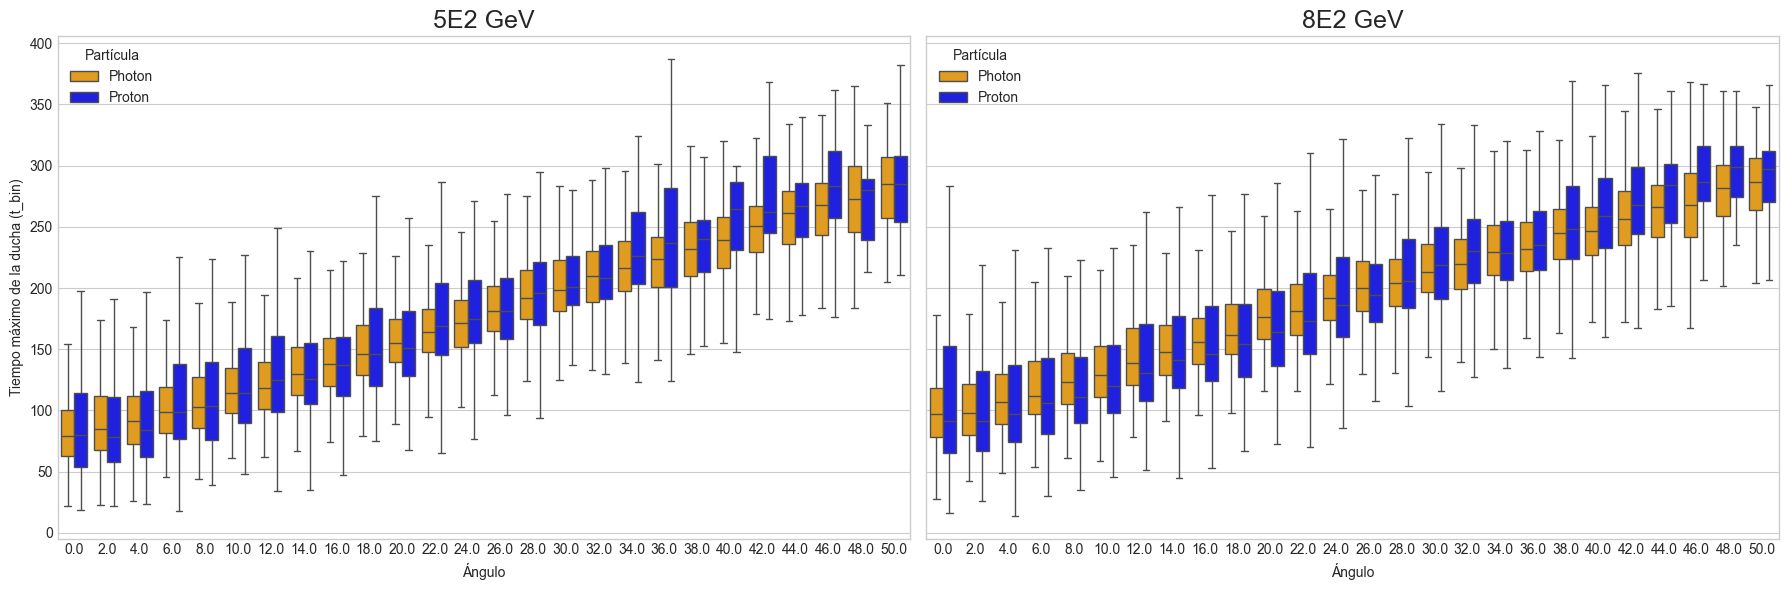

In [78]:
# Crear DataFrame para tiempos máximos por ángulo, partícula y energía (balanceado)
df_bal_time = pd.DataFrame({
    'max_time': X_ext_bal[:, 1],
    'angle': y_ang_bal,
    'label': y_lbl_bal,
    'energy': y_energy_bal
})
df_bal_time['particle'] = df_bal_time['label'].map({0: 'Proton', 1: 'Photon'})

# Visualización comparativa de la distribución de tiempos máximos (max_time) por ángulo y tipo de partícula
# para todas las energías presentes (balanceado)
unique_energies = sorted(df_bal_time['energy'].unique())
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(9 * n_energies, 6), sharey=True)

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    sns.boxplot(
        data=df_bal_time[df_bal_time['energy'] == energy_val],
        x='angle',
        y='max_time',
        hue='particle',
        palette={'Proton': 'blue', 'Photon': 'orange'},
        hue_order=['Photon', 'Proton'],
        showfliers=False,
        ax=axes[i]
    )
    axes[i].set_xlabel("Ángulo")
    axes[i].set_ylabel("Tiempo máximo de la ducha (t_bin)")
    axes[i].set_title(f"{energy_val} GeV", fontsize=18)
    axes[i].legend(title="Partícula")

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "boxplot_max_time_by_angle_energy.png"))
plt.show()


### Data split into training, validation, and test sets

In [ ]:
# Split train/val/test
train_idx, temp_idx = train_test_split(
    np.arange(len(X_seq_bal)),
    shuffle=True,
    stratify=list(zip(y_ang_bal, y_lbl_bal, y_energy_bal)),
    test_size=0.4,
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    shuffle=True,
    stratify=list(zip(y_ang_bal[temp_idx], y_lbl_bal[temp_idx], y_energy_bal[temp_idx])),
    test_size=0.5,
    random_state=42
)

X_seq_train = X_seq_bal[train_idx]
y_ang_train = y_ang_bal[train_idx]
y_lbl_train = y_lbl_bal[train_idx]
y_energy_train = y_energy_bal[train_idx]

X_seq_val   = X_seq_bal[val_idx]
y_ang_val   = y_ang_bal[val_idx]
y_lbl_val   = y_lbl_bal[val_idx]
y_energy_val = y_energy_bal[val_idx]

X_seq_test  = X_seq_bal[test_idx]
y_ang_test  = y_ang_bal[test_idx]
y_lbl_test  = y_lbl_bal[test_idx]
y_energy_test = y_energy_bal[test_idx]


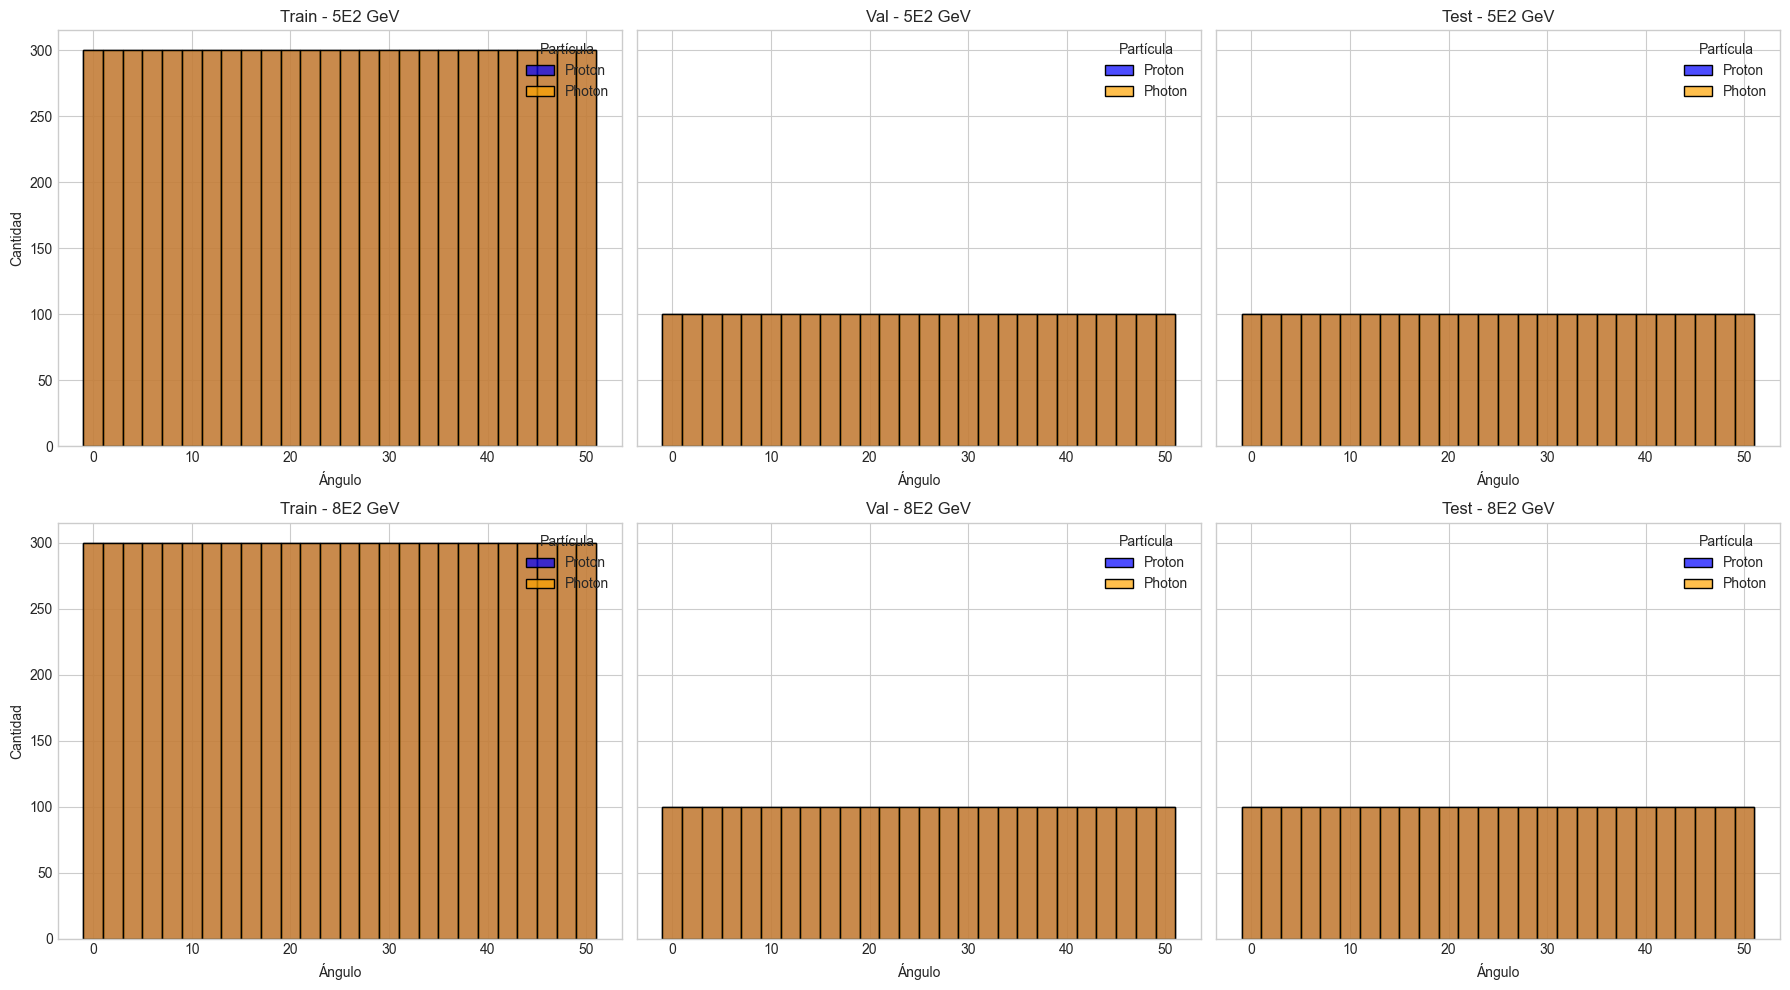

In [80]:
unique_energies = sorted(np.unique(np.concatenate([y_energy_train, y_energy_val, y_energy_test])))
fig, axes = plt.subplots(len(unique_energies), 3, figsize=(18, 5 * len(unique_energies)), sharey=True)

splits = [
    (y_ang_train, y_lbl_train, y_energy_train, "Train"),
    (y_ang_val, y_lbl_val, y_energy_val, "Val"),
    (y_ang_test, y_lbl_test, y_energy_test, "Test"),
]

for row, energy_val in enumerate(unique_energies):
    for col, (y_ang, y_lbl, y_energy, title) in enumerate(splits):
        ax = axes[row, col] if len(unique_energies) > 1 else axes[col]
        df_tmp = pd.DataFrame({'angle': y_ang, 'label': y_lbl, 'energy': y_energy})
        for lbl, part_name, color in zip([0, 1], ['Proton', 'Photon'], ['blue', 'orange']):
            sns.histplot(
                data=df_tmp[(df_tmp['energy'] == energy_val) & (df_tmp['label'] == lbl)],
                x='angle',
                bins=np.arange(-1, 52, 2),
                color=color,
                label=part_name,
                ax=ax,
                alpha=0.7
            )
        ax.set_title(f"{title} - {energy_val} GeV")
        ax.set_xlabel("Ángulo")
        ax.set_ylabel("Cantidad")
        ax.legend(title="Partícula")
plt.tight_layout()
plt.show()

### Sequence examples

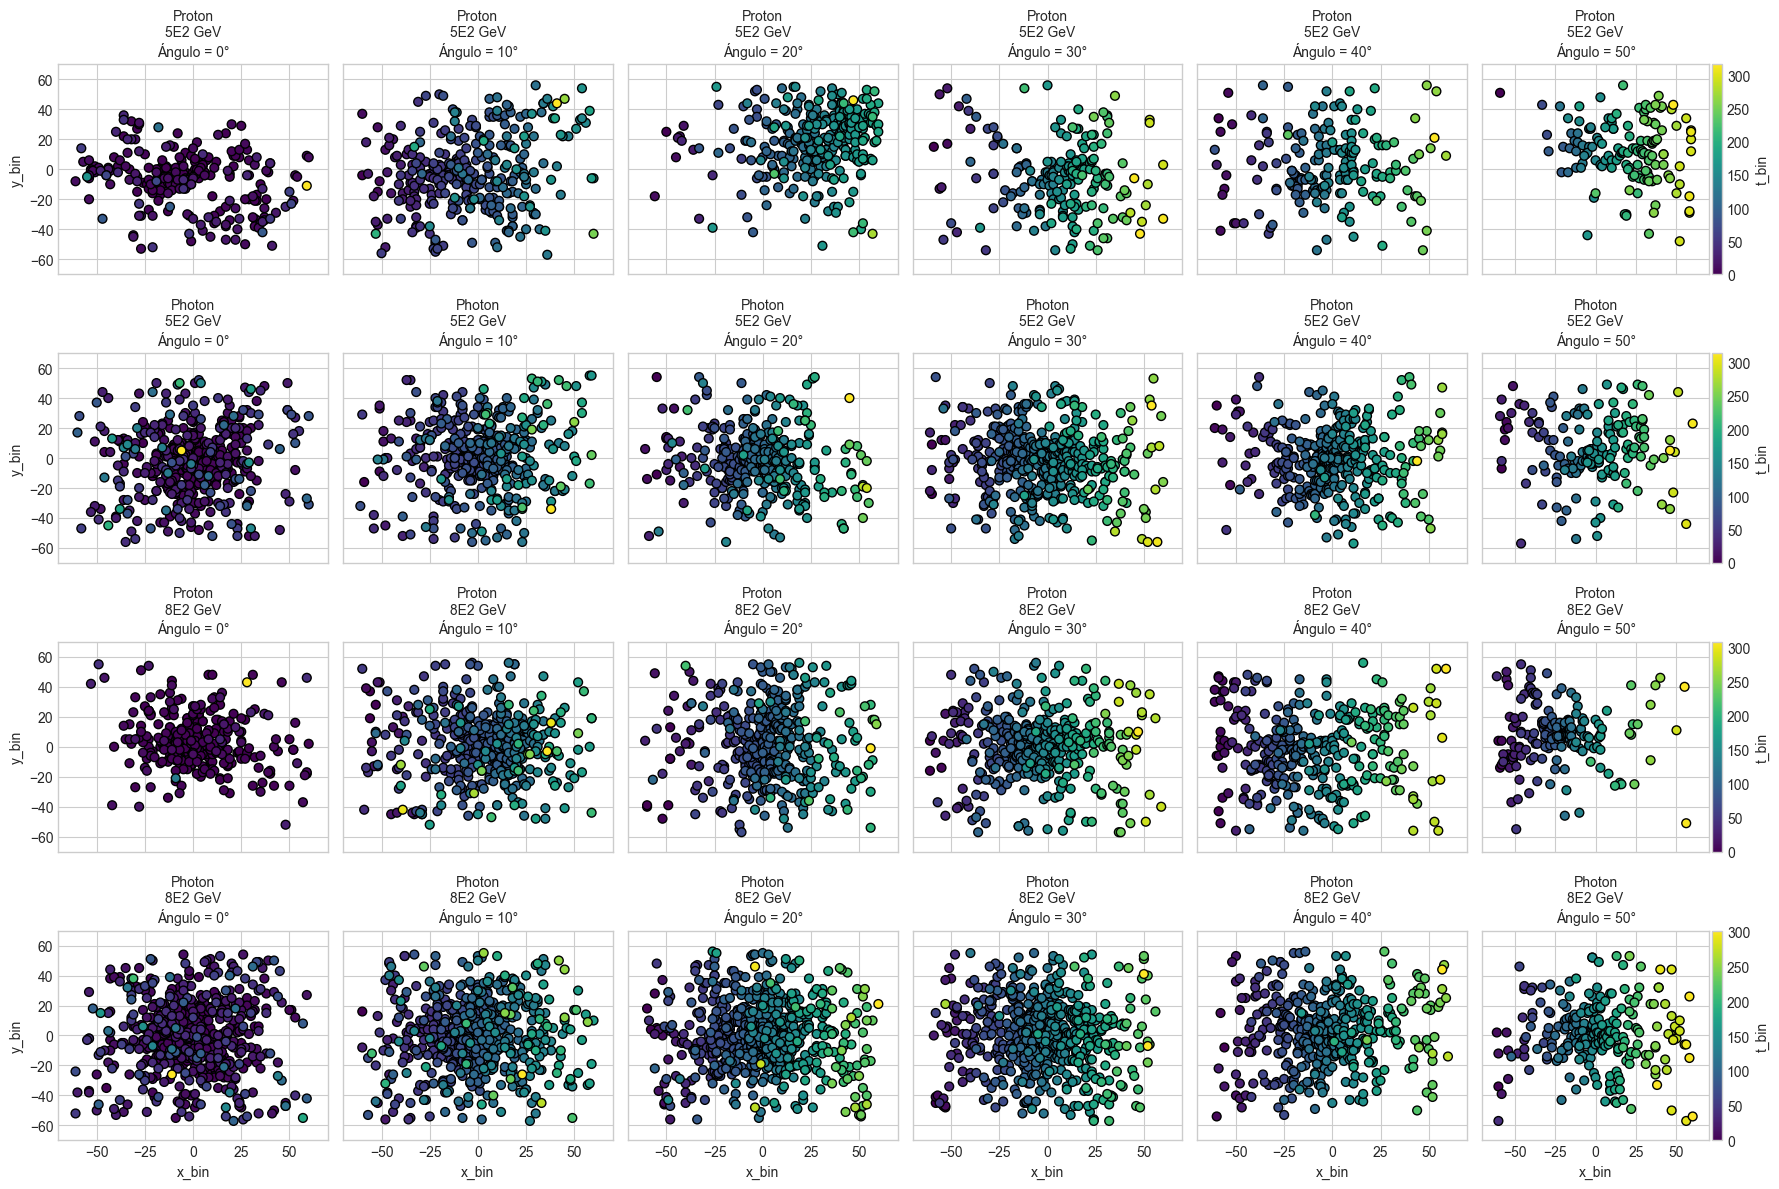

In [81]:
# Mostrar una secuencia de ejemplo con mayor número de partículas cada 10° desde 0 a 50 para ambas partículas y todas las energías en 2D (color = tiempo)

angles_to_show = np.arange(0, 51, 10)
unique_energies = sorted(df_bal['energy'].unique())
part_labels = ['Proton', 'Photon']

n_rows = len(unique_energies) * len(part_labels)
n_cols = len(angles_to_show)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharex=True, sharey=True)

for e_idx, energy_val in enumerate(unique_energies):
    for p_idx, part_name in enumerate(part_labels):
        row = e_idx * len(part_labels) + p_idx
        for col, angle_val in enumerate(angles_to_show):
            ax = axes[row, col]
            idxs = [k for k, (a, l, e) in enumerate(zip(y_ang_bal, y_lbl_bal, y_energy_bal)) if a == angle_val and l == p_idx and e == energy_val]
            if idxs:
                idx_max = max(idxs, key=lambda k: len(X_seq_bal[k]))
                seq = X_seq_bal[idx_max]
                sc = ax.scatter(seq[:, 0], seq[:, 1], c=seq[:, 2], cmap='viridis', s=40, edgecolor='k')
                ax.set_title(f"{part_name}\n{energy_val} GeV\nÁngulo = {angle_val}°", fontsize=10)
                if col == 0:
                    ax.set_ylabel("y_bin")
                if row == n_rows - 1:
                    ax.set_xlabel("x_bin")
                ax.set_xlim(-70, 70)
                ax.set_ylim(-70, 70)
                if col == n_cols - 1:
                    cbar = plt.colorbar(sc, ax=ax, pad=0.01)
                    cbar.set_label("t_bin")
            else:
                ax.set_title(f"{part_name}\n{energy_val} GeV\n{angle_val}°\nNo encontrado", fontsize=10)
                if col == 0:
                    ax.set_ylabel("y_bin")
                if row == n_rows - 1:
                    ax.set_xlabel("x_bin")
plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "ejemplo_secuencias_2D_por_energia_vertical.png"))
plt.show()


In [ ]:
# Mostrar un ejemplo de toda la información que entra al modelo
idx_ejemplo = 1 

print("Secuencia (X_seq_train):")
print(X_seq_train[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[-52.  -3.   0.]
 [-50.  -4.   1.]
 [-60.   6.   2.]
 [-51.  -3.   2.]
 [-48.  -2.   9.]
 [-32.  23.  15.]
 [-30.  23.  16.]
 [-28. -33.  17.]
 [-28.  36.  18.]
 [-24.  37.  21.]
 [-24.  37.  22.]
 [-22.  34.  23.]
 [-19.  17.  24.]
 [-15.  17.  27.]
 [ -9.  14.  31.]
 [-10.  14.  31.]
 [-10.  38.  31.]
 [-49.  13.  31.]
 [ -8.  14.  32.]
 [ -9.  30.  33.]
 [ -5.   2.  35.]
 [-15.  -6.  36.]
 [ -6.   4.  36.]
 [ -1.   0.  38.]
 [  2.  46.  41.]
 [  2.   3.  46.]
 [  5.  20.  48.]
 [-31.  49.  56.]
 [-43. -37.  59.]
 [ 28.  21.  61.]
 [ 26.  21.  62.]
 [ 30.  24.  63.]
 [ 22.  49.  64.]
 [ 28.  37.  64.]
 [ 23.  49.  65.]
 [ 31.  47.  72.]
 [ 35. -35.  74.]
 [  8. -14.  75.]
 [-16. -55. 104.]
 [ 48.  43. 105.]
 [ 47.  43. 107.]]

Etiqueta de partícula (y_lbl_train): 1
Ángulo verdadero (y_ang_train): 14.0
Energía (y_energy_train): 8E2


### Sequence normalization: spatial coordinates are normalized with MinMaxScaler to account for negative values, and time is normalized with StandardScaler to preserve its physical identity.

In [83]:
# Normaliza las secuencias usando un scaler diferente para cada variable
def normalize_sequences(seq_array, scaler_x, scaler_y, scaler_t):
	normed = []
	for seq in seq_array:
		x = scaler_x.transform(seq[:, [0]])
		y = scaler_y.transform(seq[:, [1]])
		t = scaler_t.transform(seq[:, [2]])
		seq_norm = np.concatenate([x, y, t], axis=1)
		normed.append(seq_norm)
	return np.array(normed, dtype=object)

X_seq_train_norm = normalize_sequences(X_seq_train, scaler_x, scaler_y, scaler_t)
X_seq_val_norm   = normalize_sequences(X_seq_val, scaler_x, scaler_y, scaler_t)
X_seq_test_norm  = normalize_sequences(X_seq_test, scaler_x, scaler_y, scaler_t)

In [84]:
# Mostrar un ejemplo de toda la información que entra al modelo
print("Secuencia (X_seq_train):")
print(X_seq_train_norm[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[-1.93273067e+00 -1.00617237e-01  0.00000000e+00]
 [-1.85694456e+00 -1.40438437e-01  1.32362678e-04]
 [-2.23587537e+00  2.57773519e-01  2.64725357e-04]
 [-1.89483762e+00 -1.00617237e-01  2.64725357e-04]
 [-1.78115833e+00 -6.07960448e-02  1.19126402e-03]
 [-1.17486906e+00  9.34733808e-01  1.98544003e-03]
 [-1.09908295e+00  9.34733808e-01  2.11780285e-03]
 [-1.02329671e+00 -1.29525304e+00  2.25016545e-03]
 [-1.02329671e+00  1.45240939e+00  2.38252804e-03]
 [-8.71724427e-01  1.49223053e+00  2.77961604e-03]
 [-8.71724427e-01  1.49223053e+00  2.91197887e-03]
 [-7.95938253e-01  1.37276697e+00  3.04434146e-03]
 [-6.82259023e-01  6.95806682e-01  3.17670428e-03]
 [-5.30686677e-01  6.95806682e-01  3.57379229e-03]
 [-3.03328186e-01  5.76343060e-01  4.10324289e-03]
 [-3.41221273e-01  5.76343060e-01  4.10324289e-03]
 [-3.41221273e-01  1.53205180e+00  4.10324289e-03]
 [-1.81905138e+00  5.36521852e-01  4.10324289e-03]
 [-2.65435100e-01  5.76343060e-01  4.23560571e-03]
 [-3.0

In [85]:
# Concatenar todas las secuencias normalizadas
all_seqs_norm = np.concatenate([X_seq_train_norm, X_seq_val_norm, X_seq_test_norm], axis=0)
maxlen = max(len(s) for s in all_seqs_norm)

X_seq_full_norm = pad_sequences(all_seqs_norm, maxlen=maxlen, dtype='float32', padding='post', value=0.0)

# Actualizar splits ya padeados
X_seq_train_norm = X_seq_full_norm[:len(X_seq_train_norm)]
X_seq_val_norm   = X_seq_full_norm[len(X_seq_train_norm):len(X_seq_train_norm)+len(X_seq_val_norm)]
X_seq_test_norm  = X_seq_full_norm[-len(X_seq_test_norm):]

# Actualizar también los labels de energía para los splits
y_energy_train = y_energy_bal[train_idx]
y_energy_val   = y_energy_bal[val_idx]
y_energy_test  = y_energy_bal[test_idx]

print("X_seq_full_norm shape:", X_seq_full_norm.shape)
print("X_seq_train_norm shape:", X_seq_train_norm.shape)
print("X_seq_val_norm shape:", X_seq_val_norm.shape)
print("X_seq_test_norm shape:", X_seq_test_norm.shape)
print("y_energy_train shape:", y_energy_train.shape)
print("y_energy_val shape:", y_energy_val.shape)
print("y_energy_test shape:", y_energy_test.shape)


X_seq_full_norm shape: (52000, 859, 3)
X_seq_train_norm shape: (31200, 859, 3)
X_seq_val_norm shape: (10400, 859, 3)
X_seq_test_norm shape: (10400, 859, 3)
y_energy_train shape: (31200,)
y_energy_val shape: (10400,)
y_energy_test shape: (10400,)


### Sequence padding so that each particle shower has its own length

In [ ]:
# Mostrar un ejemplo de toda la información que entra al modelo (paddeada)
print("Secuencia (X_seq_train):")
print(X_seq_train_norm[idx_ejemplo])
print("\nEtiqueta de partícula (y_lbl_train):", y_lbl_train[idx_ejemplo])
print("Ángulo verdadero (y_ang_train):", y_ang_train[idx_ejemplo])
print("Energía (y_energy_train):", y_energy_train[idx_ejemplo])

Secuencia (X_seq_train):
[[-1.9327307e+00 -1.0061724e-01  0.0000000e+00]
 [-1.8569446e+00 -1.4043844e-01  1.3236268e-04]
 [-2.2358754e+00  2.5777352e-01  2.6472536e-04]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

Etiqueta de partícula (y_lbl_train): 1
Ángulo verdadero (y_ang_train): 14.0
Energía (y_energy_train): 8E2


### Training of the **Transformers + CONV1D** model. 3 outputs: predicted energy, particle type and angle.

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Creación y entrenamiento del modelo multitarea (clasificación partícula, clasificación energía binaria, regresión ángulo)
input_seq_c = Input(shape=(maxlen, 3), name="seq_input")

# Aplicar máscara para manejar secuencias de longitud variable
mask = layers.Masking(mask_value=0.0)(input_seq_c)

# Capas Convolucionales 1D
conv1 = layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='elu')(mask)
conv1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
conv1 = layers.BatchNormalization()(conv1)

conv2 = layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='elu')(conv1)
conv2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
conv2 = layers.BatchNormalization()(conv2)

conv3 = layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='elu')(conv2)
conv3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
conv3 = layers.BatchNormalization()(conv3)

conv4 = layers.Conv1D(filters=256, kernel_size=6, padding='same', activation='elu')(conv3)
conv4 = layers.MaxPooling1D(pool_size=2, padding='same')(conv4)
conv4 = layers.BatchNormalization()(conv4)

conv5 = layers.Conv1D(filters=512, kernel_size=6, padding='same', activation='elu')(conv4)
conv5 = layers.MaxPooling1D(pool_size=2, padding='same')(conv5)
conv5 = layers.BatchNormalization()(conv5)

# Bifurcación a tres ramas de atención
# Rama para clasificación (tipo de partícula)
attn_class = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_class = layers.Add()([conv5, attn_class])
x_class = layers.LayerNormalization()(x_class)
ff_class = layers.Dense(128, activation='elu')(x_class)
ff_class = layers.Dense(512)(ff_class)
x_class = layers.Add()([x_class, ff_class])
x_class = layers.LayerNormalization()(x_class)
x_class = layers.GlobalAveragePooling1D()(x_class)
x_class = layers.Dropout(0.5)(x_class)
x_class = layers.BatchNormalization()(x_class)

# Rama para clasificación (energía binaria)
attn_energy = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_energy = layers.Add()([conv5, attn_energy])
x_energy = layers.LayerNormalization()(x_energy)
ff_energy = layers.Dense(128, activation='elu')(x_energy)
ff_energy = layers.Dense(512)(ff_energy)
x_energy = layers.Add()([x_energy, ff_energy])
x_energy = layers.LayerNormalization()(x_energy)
x_energy = layers.GlobalAveragePooling1D()(x_energy)
x_energy = layers.Dropout(0.5)(x_energy)
x_energy = layers.BatchNormalization()(x_energy)

# Rama para regresión (ángulo)
attn_angle = layers.MultiHeadAttention(num_heads=3, key_dim=64)(conv5, conv5)
x_angle = layers.Add()([conv5, attn_angle])
x_angle = layers.LayerNormalization()(x_angle)
ff_angle = layers.Dense(128, activation='elu')(x_angle)
ff_angle = layers.Dense(512)(ff_angle)
x_angle = layers.Add()([x_angle, ff_angle])
x_angle = layers.LayerNormalization()(x_angle)
x_angle = layers.GlobalAveragePooling1D()(x_angle)
x_angle = layers.Dropout(0.5)(x_angle)
x_angle = layers.BatchNormalization()(x_angle)

# Salida de clasificación (tipo de partícula)
out_class = layers.Dense(512, activation='elu')(x_class)
out_class = layers.Dense(1, activation='sigmoid', name='particle_output')(out_class)

# Salida de clasificación (energía binaria)
out_energy = layers.Dense(256, activation='elu')(x_energy)
out_energy = layers.Dense(1, activation='sigmoid', name='energy_output')(out_energy)

# Salida de regresión (ángulo)
out_angle = layers.Dense(256, activation='elu')(x_angle)
out_angle = layers.Dense(1, activation='linear', name='angle_output')(out_angle)

model_multi = models.Model(inputs=input_seq_c, outputs=[out_class, out_energy, out_angle])

# Convertir etiquetas de energía a binario (0 y 1)
le_energy = LabelEncoder()
y_energy_train_enc = le_energy.fit_transform(y_energy_train)
y_energy_val_enc = le_energy.transform(y_energy_val)

# Compilar modelo multitarea
model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003487658008462713),
    loss={
        'particle_output': 'binary_crossentropy',
        'energy_output': 'binary_crossentropy',
        'angle_output': 'mse'
    },
    metrics={
        'particle_output': [f1_metric],
        'energy_output': [f1_metric],
        'angle_output': ['mae']
    }
)

# Entrenamiento
history_multi = model_multi.fit(
    x={'seq_input': X_seq_train_norm},
    y={
        'particle_output': y_lbl_train,
        'energy_output': y_energy_train_enc,
        'angle_output': y_ang_train
    },
    validation_data=(
        {'seq_input': X_seq_val_norm},
        {
            'particle_output': y_lbl_val,
            'energy_output': y_energy_val_enc,
            'angle_output': y_ang_val
        }
    ),
    epochs=500,
    batch_size=64,
    callbacks=[cb_early, cb_rl],
    verbose=1
)

print("Modelo multitarea (clasificación partícula, energía binaria y ángulo) entrenado.")


Epoch 1/500
488/488 [==============================] - 27s 47ms/step - loss: 108.1062 - particle_output_loss: 0.5890 - energy_output_loss: 0.7201 - angle_output_loss: 106.7971 - particle_output_f1_metric: 0.6996 - energy_output_accuracy: 0.5564 - angle_output_mae: 7.5901 - val_loss: 539.7258 - val_particle_output_loss: 1.5142 - val_energy_output_loss: 0.8495 - val_angle_output_loss: 537.3622 - val_particle_output_f1_metric: 0.6825 - val_energy_output_accuracy: 0.5000 - val_angle_output_mae: 18.0718 - lr: 3.4877e-04
Epoch 2/500
488/488 [==============================] - 22s 45ms/step - loss: 41.4685 - particle_output_loss: 0.5187 - energy_output_loss: 0.6939 - angle_output_loss: 40.2559 - particle_output_f1_metric: 0.7554 - energy_output_accuracy: 0.5651 - angle_output_mae: 4.8177 - val_loss: 314.5000 - val_particle_output_loss: 0.6163 - val_energy_output_loss: 0.7485 - val_angle_output_loss: 313.1353 - val_particle_output_f1_metric: 0.4711 - val_energy_output_accuracy: 0.5547 - val_ang

In [88]:
model_multi.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 859, 3)]     0           []                               
                                                                                                  
 masking_3 (Masking)            (None, 859, 3)       0           ['seq_input[0][0]']              
                                                                                                  
 conv1d_15 (Conv1D)             (None, 859, 32)      224         ['masking_3[0][0]']              
                                                                                                  
 max_pooling1d_15 (MaxPooling1D  (None, 430, 32)     0           ['conv1d_15[0][0]']              
 )                                                                                          

### Use of keras_tuner to find the hyperparameters that best fit the model. _(It is commented out because once the hyperparameters are found, it is not necessary to use it again unless you are looking for another architecture)_

In [89]:
# def build_multitask_model(hp):
#     input_seq_c = Input(shape=(maxlen, 3), name="seq_input")
#     mask = layers.Masking(mask_value=0.0)(input_seq_c)
#
#     # Hyperparameters for Conv1D layers
#     filters1 = hp.Choice('filters1', [32, 64])
#     kernel1 = hp.Choice('kernel1', [2, 3])
#     filters2 = hp.Choice('filters2', [64, 128])
#     kernel2 = hp.Choice('kernel2', [2, 3, 4])
#     filters3 = hp.Choice('filters3', [128, 256])
#     kernel3 = hp.Choice('kernel3', [4, 6])
#     filters4 = hp.Choice('filters4', [256, 512])
#     kernel4 = hp.Choice('kernel4', [6, 8])
#     filters5 = hp.Choice('filters5', [512])
#     kernel5 = hp.Choice('kernel5', [6, 8])
#
#     conv1 = layers.Conv1D(filters=filters1, kernel_size=kernel1, padding='same', activation='elu')(mask)
#     conv1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
#     conv1 = layers.BatchNormalization()(conv1)
#
#     conv2 = layers.Conv1D(filters=filters2, kernel_size=kernel2, padding='same', activation='elu')(conv1)
#     conv2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
#     conv2 = layers.BatchNormalization()(conv2)
#
#     conv3 = layers.Conv1D(filters=filters3, kernel_size=kernel3, padding='same', activation='elu')(conv2)
#     conv3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
#     conv3 = layers.BatchNormalization()(conv3)
#
#     conv4 = layers.Conv1D(filters=filters4, kernel_size=kernel4, padding='same', activation='elu')(conv3)
#     conv4 = layers.MaxPooling1D(pool_size=2, padding='same')(conv4)
#     conv4 = layers.BatchNormalization()(conv4)
#
#     conv5 = layers.Conv1D(filters=filters5, kernel_size=kernel5, padding='same', activation='elu')(conv4)
#     conv5 = layers.MaxPooling1D(pool_size=2, padding='same')(conv5)
#     conv5 = layers.BatchNormalization()(conv5)
#
#     # Attention hyperparameters
#     attn_heads = hp.Choice('attn_heads', [2, 3, 4])
#     attn_dim = hp.Choice('attn_dim', [32, 64, 128])
#
#     # Classification branch
#     attn_class = layers.MultiHeadAttention(num_heads=attn_heads, key_dim=attn_dim)(conv5, conv5)
#     x_class = layers.Add()([conv5, attn_class])
#     x_class = layers.LayerNormalization()(x_class)
#     ff_class_units = hp.Choice('ff_class_units', [128, 256])
#     ff_class = layers.Dense(ff_class_units, activation='elu')(x_class)
#     ff_class = layers.Dense(filters5)(ff_class)
#     x_class = layers.Add()([x_class, ff_class])
#     x_class = layers.LayerNormalization()(x_class)
#     x_class = layers.GlobalAveragePooling1D()(x_class)
#     dropout_class = hp.Float('dropout_class', 0.3, 0.7, step=0.1)
#     x_class = layers.Dropout(dropout_class)(x_class)
#     x_class = layers.BatchNormalization()(x_class)
#
#     out_class_units = hp.Choice('out_class_units', [128, 256, 512])
#     out_class = layers.Dense(out_class_units, activation='elu')(x_class)
#     out_class = layers.Dense(1, activation='sigmoid', name='particle_output')(out_class)
#
#     # Regression branch
#     attn_angle = layers.MultiHeadAttention(num_heads=attn_heads, key_dim=attn_dim)(conv5, conv5)
#     x_angle = layers.Add()([conv5, attn_angle])
#     x_angle = layers.LayerNormalization()(x_angle)
#     ff_angle_units = hp.Choice('ff_angle_units', [128, 256])
#     ff_angle = layers.Dense(ff_angle_units, activation='elu')(x_angle)
#     ff_angle = layers.Dense(filters5)(ff_angle)
#     x_angle = layers.Add()([x_angle, ff_angle])
#     x_angle = layers.LayerNormalization()(x_angle)
#     x_angle = layers.GlobalAveragePooling1D()(x_angle)
#     dropout_angle = hp.Float('dropout_angle', 0.3, 0.7, step=0.1)
#     x_angle = layers.Dropout(dropout_angle)(x_angle)
#     x_angle = layers.BatchNormalization()(x_angle)
#
#     out_angle_units = hp.Choice('out_angle_units', [128, 256])
#     out_angle = layers.Dense(out_angle_units, activation='elu')(x_angle)
#     out_angle = layers.Dense(1, activation='linear', name='angle_output')(out_angle)
#
#     model = models.Model(inputs=input_seq_c, outputs=[out_class, out_angle])
#
#     lr = hp.Float('lr', 1e-5, 1e-3, sampling='log')
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#         loss={'particle_output': 'binary_crossentropy', 'angle_output': 'mse'},
#         metrics={'particle_output': [f1_metric], 'angle_output': ['mae']}
#     )
#     return model
#
# tuner = kt.BayesianOptimization(
#     build_multitask_model,
#     objective=kt.Objective("loss", direction="min"),
#     max_trials=20,
#     directory='kt_multitask_tuning',
#     project_name='multitask_class_angle'
# )
#
# tuner.search(
#     x={'seq_input': X_seq_train_norm},
#     y={'particle_output': y_lbl_train, 'angle_output': y_ang_train},
#     validation_data=(
#         {'seq_input': X_seq_val_norm},
#         {'particle_output': y_lbl_val, 'angle_output': y_ang_val}
#     ),
#     epochs=10,
#     batch_size=64,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
#     ],
#     verbose=1
# )
#
# best_model = tuner.get_best_models(1)[0]
# best_hp = tuner.get_best_hyperparameters(1)[0]
# print("Mejor modelo multitarea encontrado y entrenado.")
# print("Mejores hiperparámetros encontrados:")
# for hp_name in best_hp.values.keys():
#     print(f"{hp_name}: {best_hp.get(hp_name)}")
#
# # --- EXPLICACIÓN DEL WARNING ---
# # Este warning ocurre porque Keras Tuner guarda y restaura modelos usando checkpoints de TensorFlow.
# # Cuando se restaura el modelo, puede que algunas variables del optimizador (como iter, beta_1, beta_2, decay, learning_rate)
# # no estén presentes o no sean necesarias para la inferencia, especialmente si solo se carga el modelo para predecir y no para continuar el entrenamiento.
# # Es seguro ignorar este warning si solo vas a usar el modelo para predicción o evaluación.
# # Si quieres evitar el warning, puedes recompilar el modelo después de cargarlo:
# best_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get('lr')),
#     loss={'particle_output': 'binary_crossentropy', 'angle_output': 'mse'},
#     metrics={'particle_output': [f1_metric], 'angle_output': ['mae']}
# )

### Results Visualization

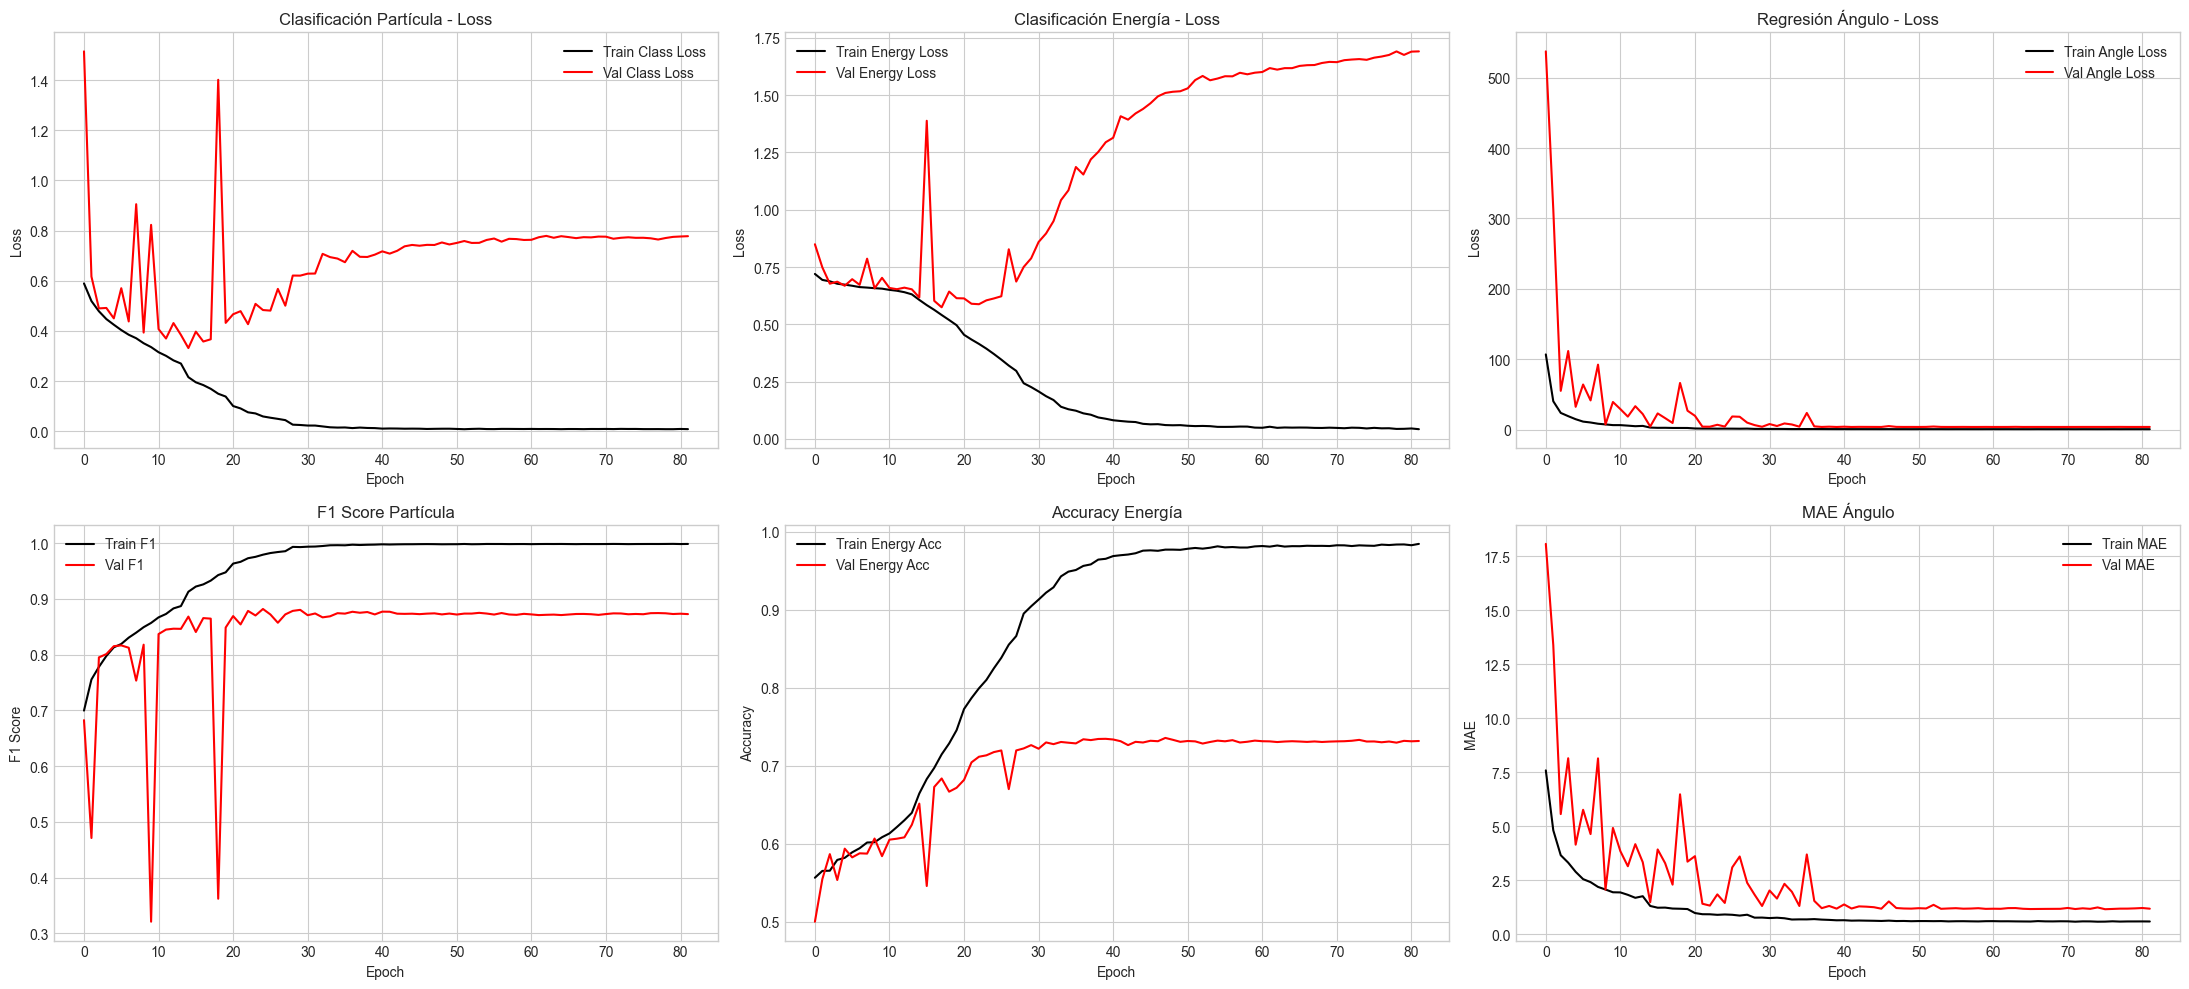

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

# Pérdida de clasificación (partícula)
axes[0, 0].plot(history_multi.history['particle_output_loss'], label='Train Class Loss', color='black')
axes[0, 0].plot(history_multi.history['val_particle_output_loss'], label='Val Class Loss', color='red')
axes[0, 0].set_title('Clasificación Partícula - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Pérdida de clasificación (energía)
axes[0, 1].plot(history_multi.history['energy_output_loss'], label='Train Energy Loss', color='black')
axes[0, 1].plot(history_multi.history['val_energy_output_loss'], label='Val Energy Loss', color='red')
axes[0, 1].set_title('Clasificación Energía - Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Pérdida de regresión de ángulo
axes[0, 2].plot(history_multi.history['angle_output_loss'], label='Train Angle Loss', color='black')
axes[0, 2].plot(history_multi.history['val_angle_output_loss'], label='Val Angle Loss', color='red')
axes[0, 2].set_title('Regresión Ángulo - Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# F1-score (clasificación partícula)
axes[1, 0].plot(history_multi.history['particle_output_f1_metric'], label='Train F1', color='black')
axes[1, 0].plot(history_multi.history['val_particle_output_f1_metric'], label='Val F1', color='red')
axes[1, 0].set_title('F1 Score Partícula')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy (clasificación energía)
axes[1, 1].plot(history_multi.history['energy_output_accuracy'], label='Train Energy Acc', color='black')
axes[1, 1].plot(history_multi.history['val_energy_output_accuracy'], label='Val Energy Acc', color='red')
axes[1, 1].set_title('Accuracy Energía')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

# MAE (regresión de ángulo)
axes[1, 2].plot(history_multi.history['angle_output_mae'], label='Train MAE', color='black')
axes[1, 2].plot(history_multi.history['val_angle_output_mae'], label='Val MAE', color='red')
axes[1, 2].set_title('MAE Ángulo')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "multitask_all_curves.png"))
plt.show()


In [91]:
# Evaluación en test para el modelo multitarea (incluyendo energía)
y_energy_test_bin = (y_energy_test == '8E2').astype(int)
test_res_multi = model_multi.evaluate(
    x={'seq_input': X_seq_test_norm},
    y={
        'particle_output': y_lbl_test,
        'energy_output': y_energy_test_bin,
        'angle_output': y_ang_test
    },
    verbose=1
)
print("Resultados finales en Test (Multitarea - Clasificación, Energía y Ángulo):", test_res_multi)


325/325 [==============================] - 5s 15ms/step - loss: 6.0119 - particle_output_loss: 0.7376 - energy_output_loss: 1.7242 - angle_output_loss: 3.5500 - particle_output_f1_metric: 0.8776 - energy_output_accuracy: 0.7234 - angle_output_mae: 1.1550
Resultados finales en Test (Multitarea - Clasificación, Energía y Ángulo): [6.011862754821777, 0.7376022338867188, 1.7242285013198853, 3.5500307083129883, 0.8776230216026306, 0.7233653664588928, 1.1549972295761108]


In [92]:
# Generar predicciones para el set de test usando el modelo multitarea
y_pred_cl, y_pred_energy, y_pred_angle = model_multi.predict({'seq_input': X_seq_test_norm}, verbose=1)
y_pred_cl = (y_pred_cl > 0.5).astype(int).flatten()         # Clasificación binaria partícula
y_pred_energy = (y_pred_energy > 0.5).astype(int).flatten() # Clasificación binaria energía
y_pred_angle = y_pred_angle.flatten()

# Formar DataFrame de predicciones
df_pred = pd.DataFrame({
    'y_true_label': y_lbl_test,
    'y_pred_label': y_pred_cl,
    'y_true_energy': y_energy_test,
    'y_pred_energy': y_pred_energy,
    'y_true_angle': y_ang_test,
    'y_pred_angle': y_pred_angle
})


325/325 [==============================] - 3s 8ms/step


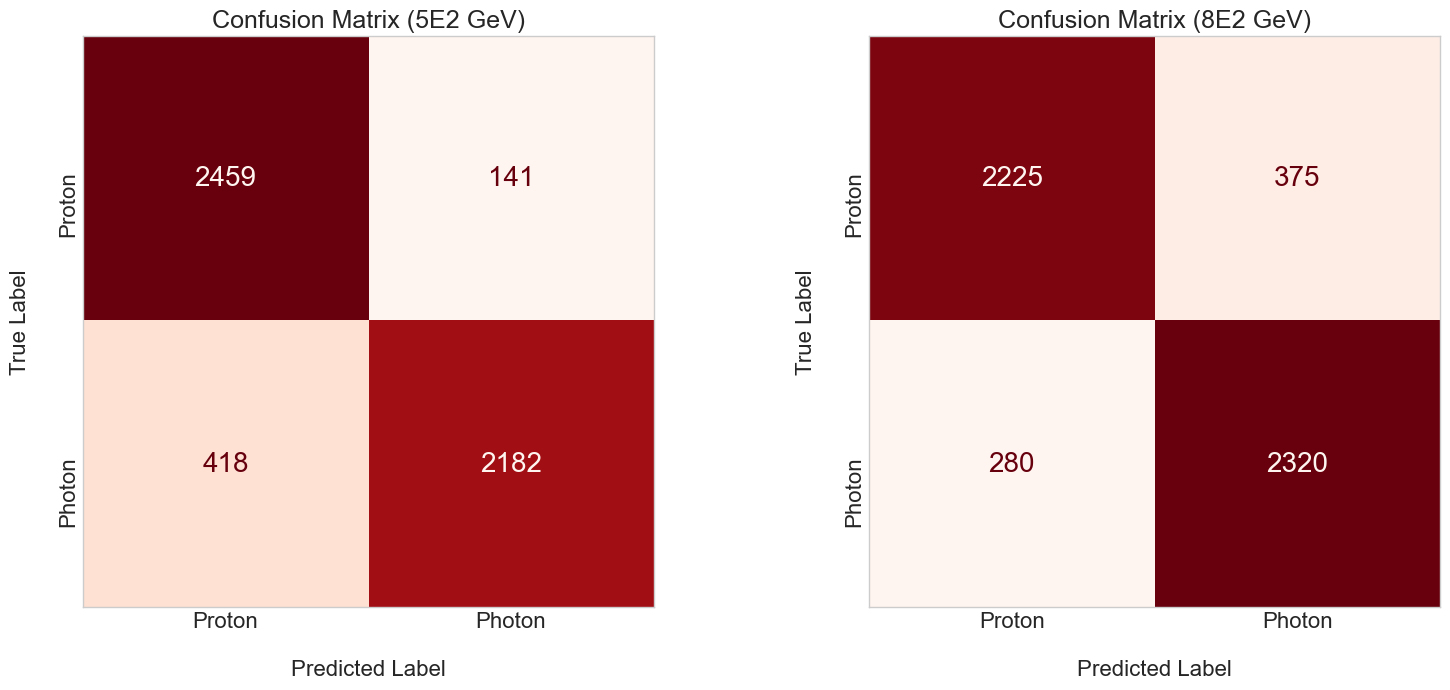

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

unique_energies = np.unique(y_energy_test)
n_energies = len(unique_energies)
fig, axes = plt.subplots(1, n_energies, figsize=(8 * n_energies, 7))

if n_energies == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    mask = y_energy_test == energy_val
    cm = confusion_matrix(y_lbl_test[mask], y_pred_cl[mask], labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Proton', 'Photon'])
    disp.plot(ax=axes[i], cmap='Reds', colorbar=False, text_kw={'fontsize': 20})
    axes[i].set_xlabel("Predicted Label", fontsize=16, labelpad=20)
    axes[i].set_ylabel("True Label", fontsize=16, labelpad=20)
    axes[i].set_xticklabels(['Proton', 'Photon'], fontsize=16)
    axes[i].set_yticklabels(['Proton', 'Photon'], fontsize=16, rotation=90)
    axes[i].grid(False)
    axes[i].set_title(f"Confusion Matrix ({energy_val} GeV)", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "confusion_matrix_by_energy.png"))
plt.show()

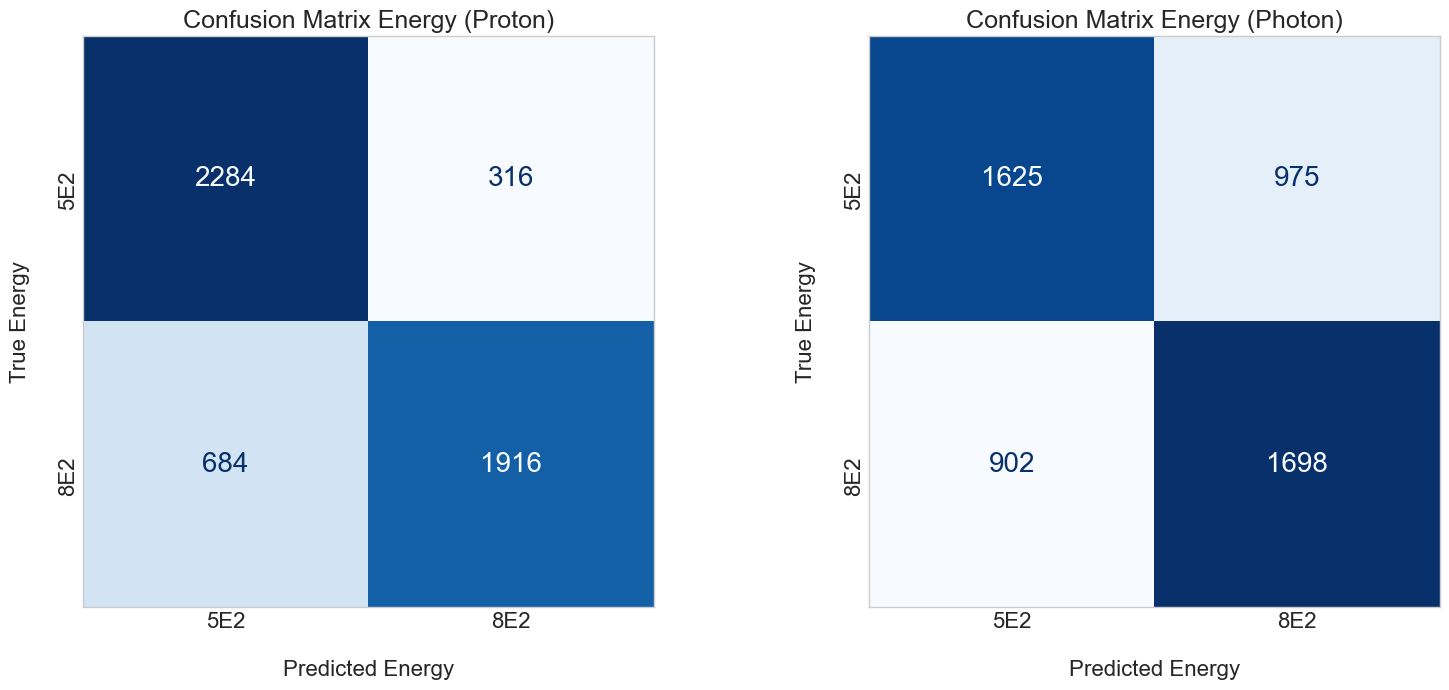

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

unique_energies = np.unique(y_energy_test)
energy_to_idx = {e: i for i, e in enumerate(unique_energies)}
n_energies = len(unique_energies)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for i, (label_value, label_name) in enumerate([(0, 'Proton'), (1, 'Photon')]):
    mask = y_lbl_test == label_value
    # Map true and predicted energies to integer indices
    y_true_energy_idx = np.vectorize(energy_to_idx.get)(y_energy_test[mask])
    y_pred_energy_idx = y_pred_energy[mask]
    cm = confusion_matrix(y_true_energy_idx, y_pred_energy_idx, labels=range(n_energies))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_energies)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False, text_kw={'fontsize': 20})
    axes[i].set_xlabel("Predicted Energy", fontsize=16, labelpad=20)
    axes[i].set_ylabel("True Energy", fontsize=16, labelpad=20)
    axes[i].set_xticklabels(unique_energies, fontsize=16)
    axes[i].set_yticklabels(unique_energies, fontsize=16, rotation=90)
    axes[i].grid(False)
    axes[i].set_title(f"Confusion Matrix Energy ({label_name})", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "confusion_matrix_energy_by_particle.png"))
plt.show()

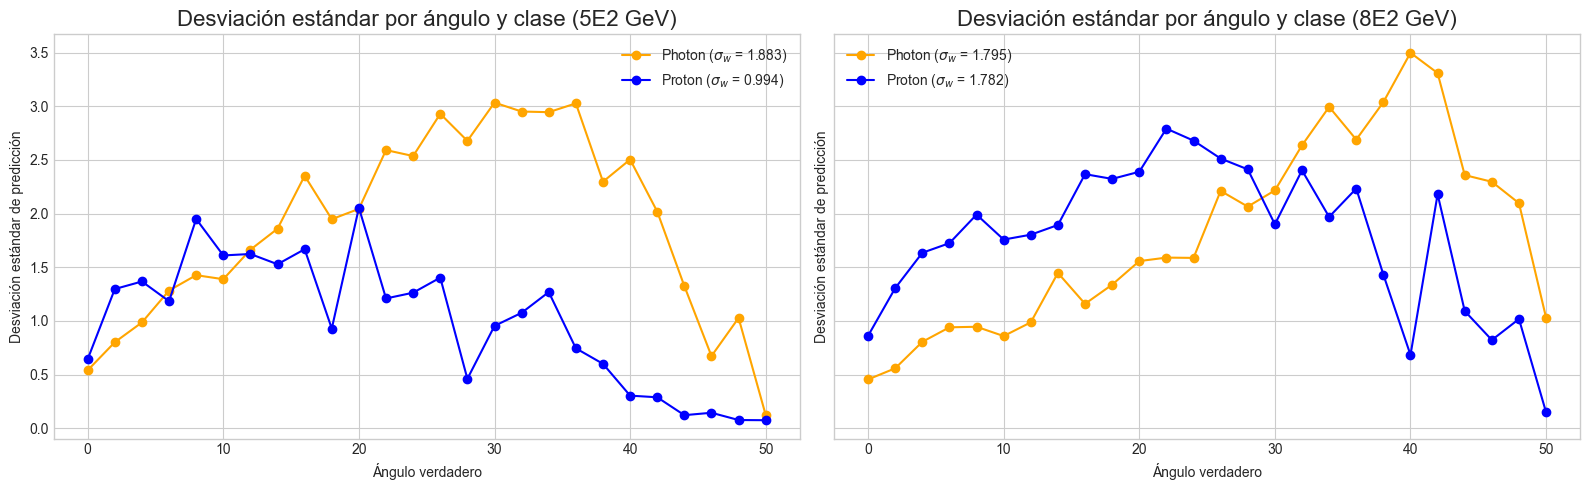

In [95]:
# Calcular la desviación estándar de las predicciones por ángulo y clase para todas las energías presentes
unique_angles = np.unique(y_ang_test)
unique_energies = np.unique(y_energy_test)

fig, axes = plt.subplots(1, len(unique_energies), figsize=(8 * len(unique_energies), 5), sharey=True)

if len(unique_energies) == 1:
    axes = [axes]

for i, energy_val in enumerate(unique_energies):
    mask_energy = y_energy_test == energy_val
    stds_photon = []
    stds_proton = []
    for ang in unique_angles:
        preds_photon = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 1) & mask_energy]
        preds_proton = y_pred_angle[(y_ang_test == ang) & (y_lbl_test == 0) & mask_energy]
        stds_photon.append(np.std(preds_photon))
        stds_proton.append(np.std(preds_proton))
    mean_std_photon = np.nanmean(stds_photon)
    mean_std_proton = np.nanmean(stds_proton)

    ax = axes[i]
    ax.plot(unique_angles, stds_photon, marker='o', label=f'Photon ($\sigma_w$ = {mean_std_photon:.3f})', color='orange')
    ax.plot(unique_angles, stds_proton, marker='o', label=f'Proton ($\sigma_w$ = {mean_std_proton:.3f})', color='blue')
    ax.set_xlabel("Ángulo verdadero")
    ax.set_ylabel("Desviación estándar de predicción")
    ax.set_title(f"Desviación estándar por ángulo y clase ({energy_val} GeV)", fontsize=16)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


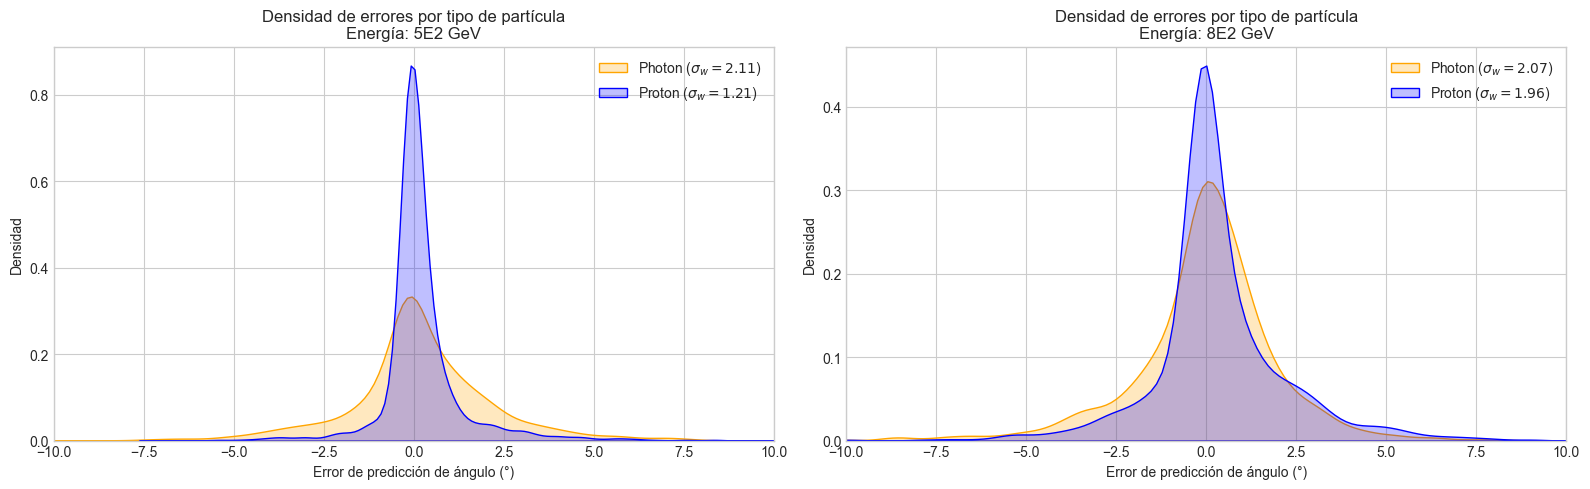

In [96]:
# KDE de errores de predicción de ángulo por tipo de partícula y energía (adaptado a cualquier cantidad de energías)
unique_energies = np.unique(y_energy_test)
n_energies = len(unique_energies)
plt.figure(figsize=(8 * n_energies, 5))

for i, energy_val in enumerate(unique_energies):
    plt.subplot(1, n_energies, i + 1)
    mask = y_energy_test == energy_val
    errors_photon = (y_pred_angle - y_ang_test)[(y_lbl_test == 1) & mask]
    errors_proton = (y_pred_angle - y_ang_test)[(y_lbl_test == 0) & mask]
    mean_std_photon = np.std(errors_photon)
    mean_std_proton = np.std(errors_proton)
    sns.kdeplot(errors_photon, label=f'Photon ($\sigma_w = {mean_std_photon:.2f}$)', fill=True, color='orange')
    sns.kdeplot(errors_proton, label=f'Proton ($\sigma_w = {mean_std_proton:.2f}$)', fill=True, color='blue')
    plt.xlabel("Error de predicción de ángulo (°)")
    plt.ylabel("Densidad")
    plt.title(f"Densidad de errores por tipo de partícula\nEnergía: {energy_val} GeV")
    plt.xlim(-10, 10)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(predicts_dir, "kde_error_prediccion_angulo_por_energia.png"))
plt.show()


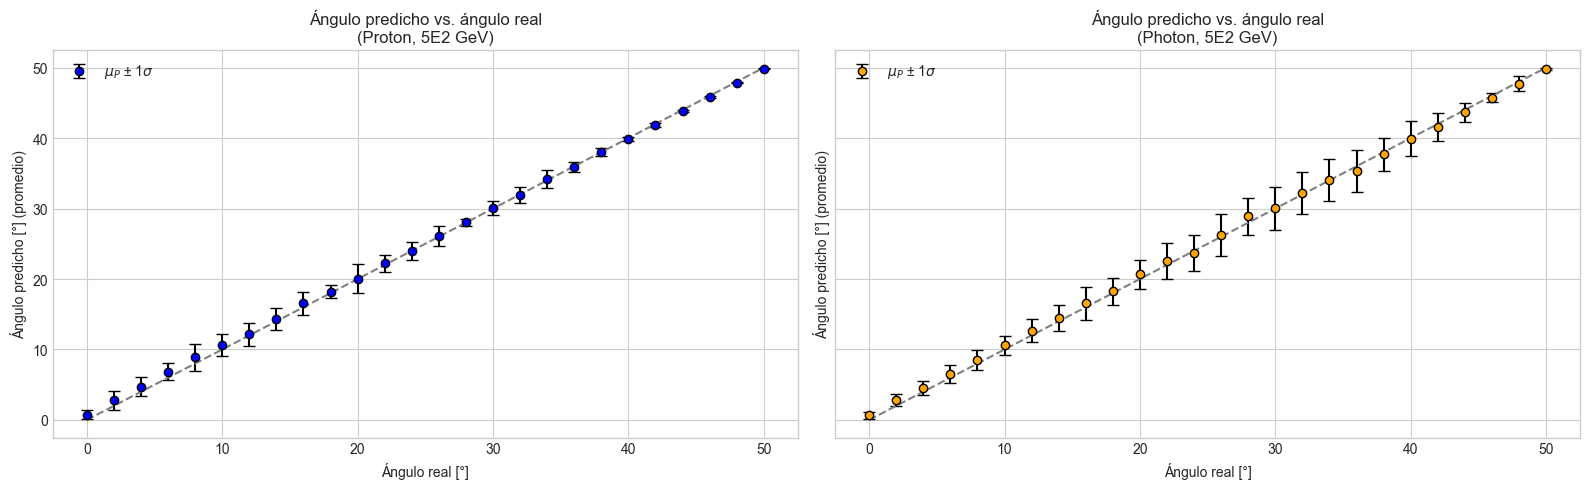

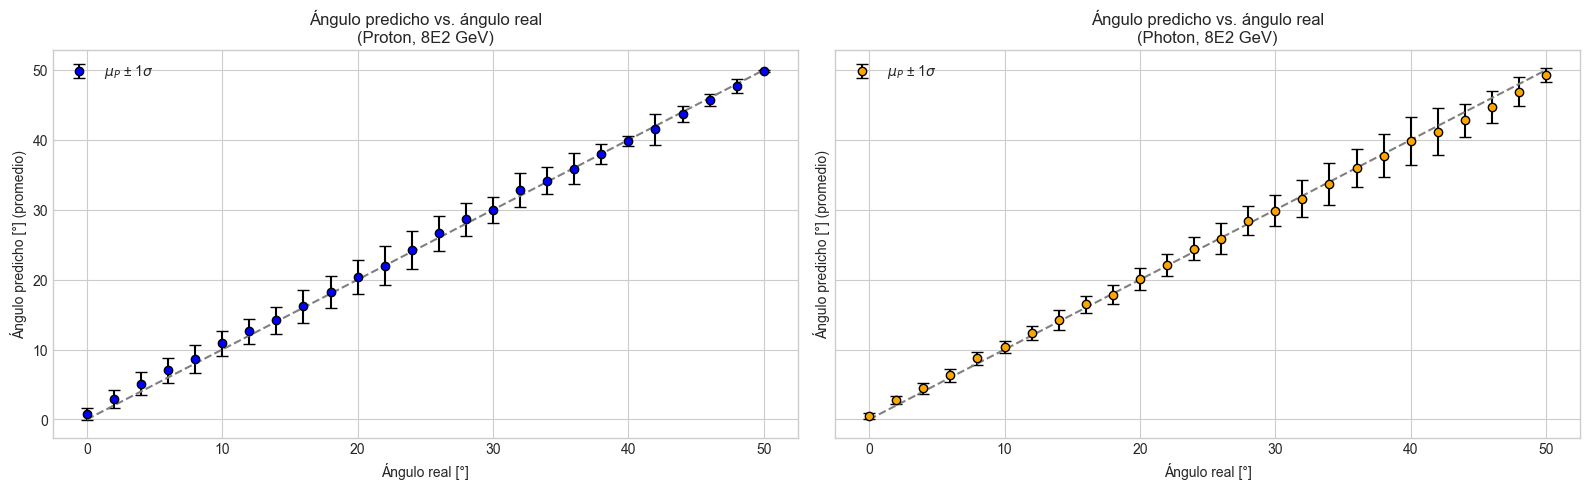

In [101]:
# Obtener las energías únicas automáticamente desde y_energy_test
unique_energies = np.unique(y_energy_test)

# Visualizar promedio y desviación estándar de predicciones por ángulo, clase y energía
for energy_val in unique_energies:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    mask_energy = y_energy_test == energy_val
    for ax, (label_value, label_name) in zip(axes, {0: 'Proton', 1: 'Photon'}.items()):
        means = []
        stds = []
        for ang in unique_angles:
            mask = (y_ang_test == ang) & (y_lbl_test == label_value) & mask_energy
            preds = y_pred_angle[mask]
            means.append(np.mean(preds) if preds.size > 0 else np.nan)
            stds.append(np.std(preds) if preds.size > 0 else np.nan)
        means = np.array(means)
        stds = np.array(stds)

        color = 'blue' if label_value == 0 else 'orange'
        ax.errorbar(unique_angles, means, yerr=stds, fmt='o', capsize=4,
                    ecolor='black', color=color, markerfacecolor=color,
                    markeredgecolor='black', label='$\mu_P$ ± 1$\sigma$')
        ax.plot(unique_angles, unique_angles, '--', color='gray')
        ax.set_xlabel("Ángulo real [°]")
        ax.set_ylabel("Ángulo predicho [°] (promedio)")
        ax.set_title(f"Ángulo predicho vs. ángulo real\n({label_name}, {energy_val} GeV)")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(predicts_dir, f"pred_vs_real_angle_by_class_{energy_val}.png"))
    plt.show()


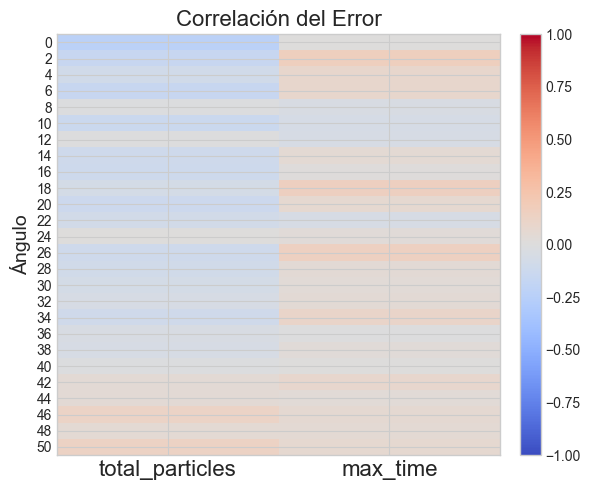

In [100]:
# Calcula el error de predicción de ángulo
angle_errors = y_pred_angle - y_ang_test

# DataFrame con información relevante
df_corr = pd.DataFrame({
    'error': angle_errors,
    'total_particles': X_ext_bal[test_idx][:, 0],
    'max_time': X_ext_bal[test_idx][:, 1],
    'angle': y_ang_test
})

# Calcula la correlación para cada ángulo y muestra como mapa de calor
corrs = []
for ang in unique_angles:
    df_a = df_corr[df_corr['angle'] == ang]
    if len(df_a) > 2:
        corr = df_a[['error', 'total_particles', 'max_time']].corr()
        corrs.append(corr.values)
    else:
        corrs.append(np.full((3,3), np.nan))

corrs = np.array(corrs)  # shape: (n_angles, 3, 3)

# Solo el primer gráfico: correlación del error con las otras variables
i = 0  # 'error'
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
labels = ['error', 'total_particles', 'max_time']

data = np.delete(corrs[:, i, :], i, axis=1)
im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm',
               extent=[-0.5, 1.5, unique_angles[-1]+1, unique_angles[0]-1])
xtick_labels = [l for j, l in enumerate(labels) if j != i]
ax.set_xticks(range(2))
ax.set_xticklabels(xtick_labels, fontsize=16)  # Aumenta el fontsize aquí
ax.set_yticks(unique_angles)
ax.set_yticklabels([f"{a:.0f}" for a in unique_angles])
ax.set_title(f"Correlación del Error", fontsize=16)
ax.set_ylabel("Ángulo", fontsize=14)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
